In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [28]:
#client.close()

In [27]:
import os
import dask
import dask.dataframe as dd
import pandas as pd
import numpy as np

# Read in a single file to dask dataframe

In [3]:
filename = os.path.join('example-data', 'iris', 'iris_1.csv')
df = dd.read_csv(filename)

In [4]:
df = dd.read_csv(filename,
                 dtype={
                        'sepal_length': float,
                        'sepal_width': float,
                        'petal_length': float,
                        'petal_width': float,
                        'variety': str,
                 }
                )

In [5]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [10]:
df.tail() 

,sepal_length,sepal_width,petal_length,petal_width,variety
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica
149,5.9,3.0,5.1,1.8,Virginica


In [5]:
# load and count number of rows
len(df)

150

# Read in multiple files to dask dataframe

In [62]:
filenames = os.path.join('example-data', 'iris', 'iris_*.csv')
filenames

'example-data/iris/iris_*.csv'

In [63]:
df = dd.read_csv(filenames)

In [64]:
df

,sepal_length,sepal_width,petal_length,petal_width,variety
npartitions=3,,,,,
,float64,float64,float64,float64,object
,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [65]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [66]:
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,variety
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica
149,5.9,3.0,5.1,1.8,Virginica


In [69]:
df.sepal_length.max()

dd.Scalar<series-..., dtype=float64>

In [70]:
df.sepal_length.max().compute()

7.9

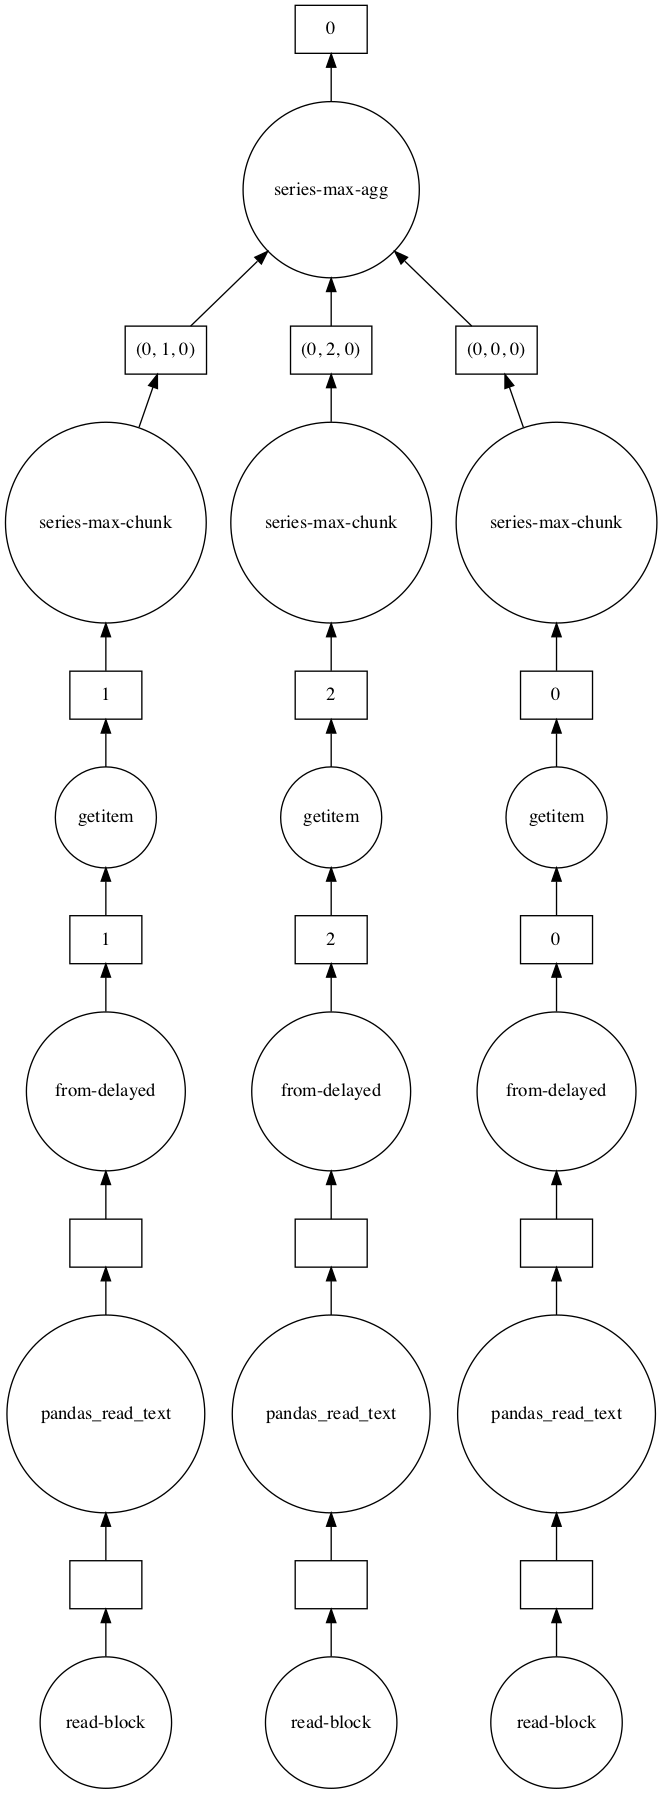

In [71]:
df.sepal_length.max().visualize()

# Exploratory stats

In [72]:
len(df) # 3 x 150 rows per dataset = 450

450

In [75]:
df[df.petal_width > 0.4].groupby('variety').variety.count().compute() # example 1. complex chain of operations

variety
Setosa          6
Versicolor    150
Virginica     150
Name: variety, dtype: int64

In [76]:
df.groupby("variety").petal_width.mean().compute() # example 2. complex chain of operations

variety
Setosa        0.246
Versicolor    1.326
Virginica     2.026
Name: petal_width, dtype: float64

# Comparing different execution calls

In [77]:
mean_delay = df.groupby("variety").petal_width.mean()
std_delay = df.groupby("variety").petal_width.std()

In [80]:
# individual calls for compute

In [79]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 62.9 ms, sys: 7.75 ms, total: 70.6 ms
Wall time: 182 ms


In [82]:
# multiple calls using dask.compute 

In [81]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 47.2 ms, sys: 5.07 ms, total: 52.3 ms
Wall time: 118 ms


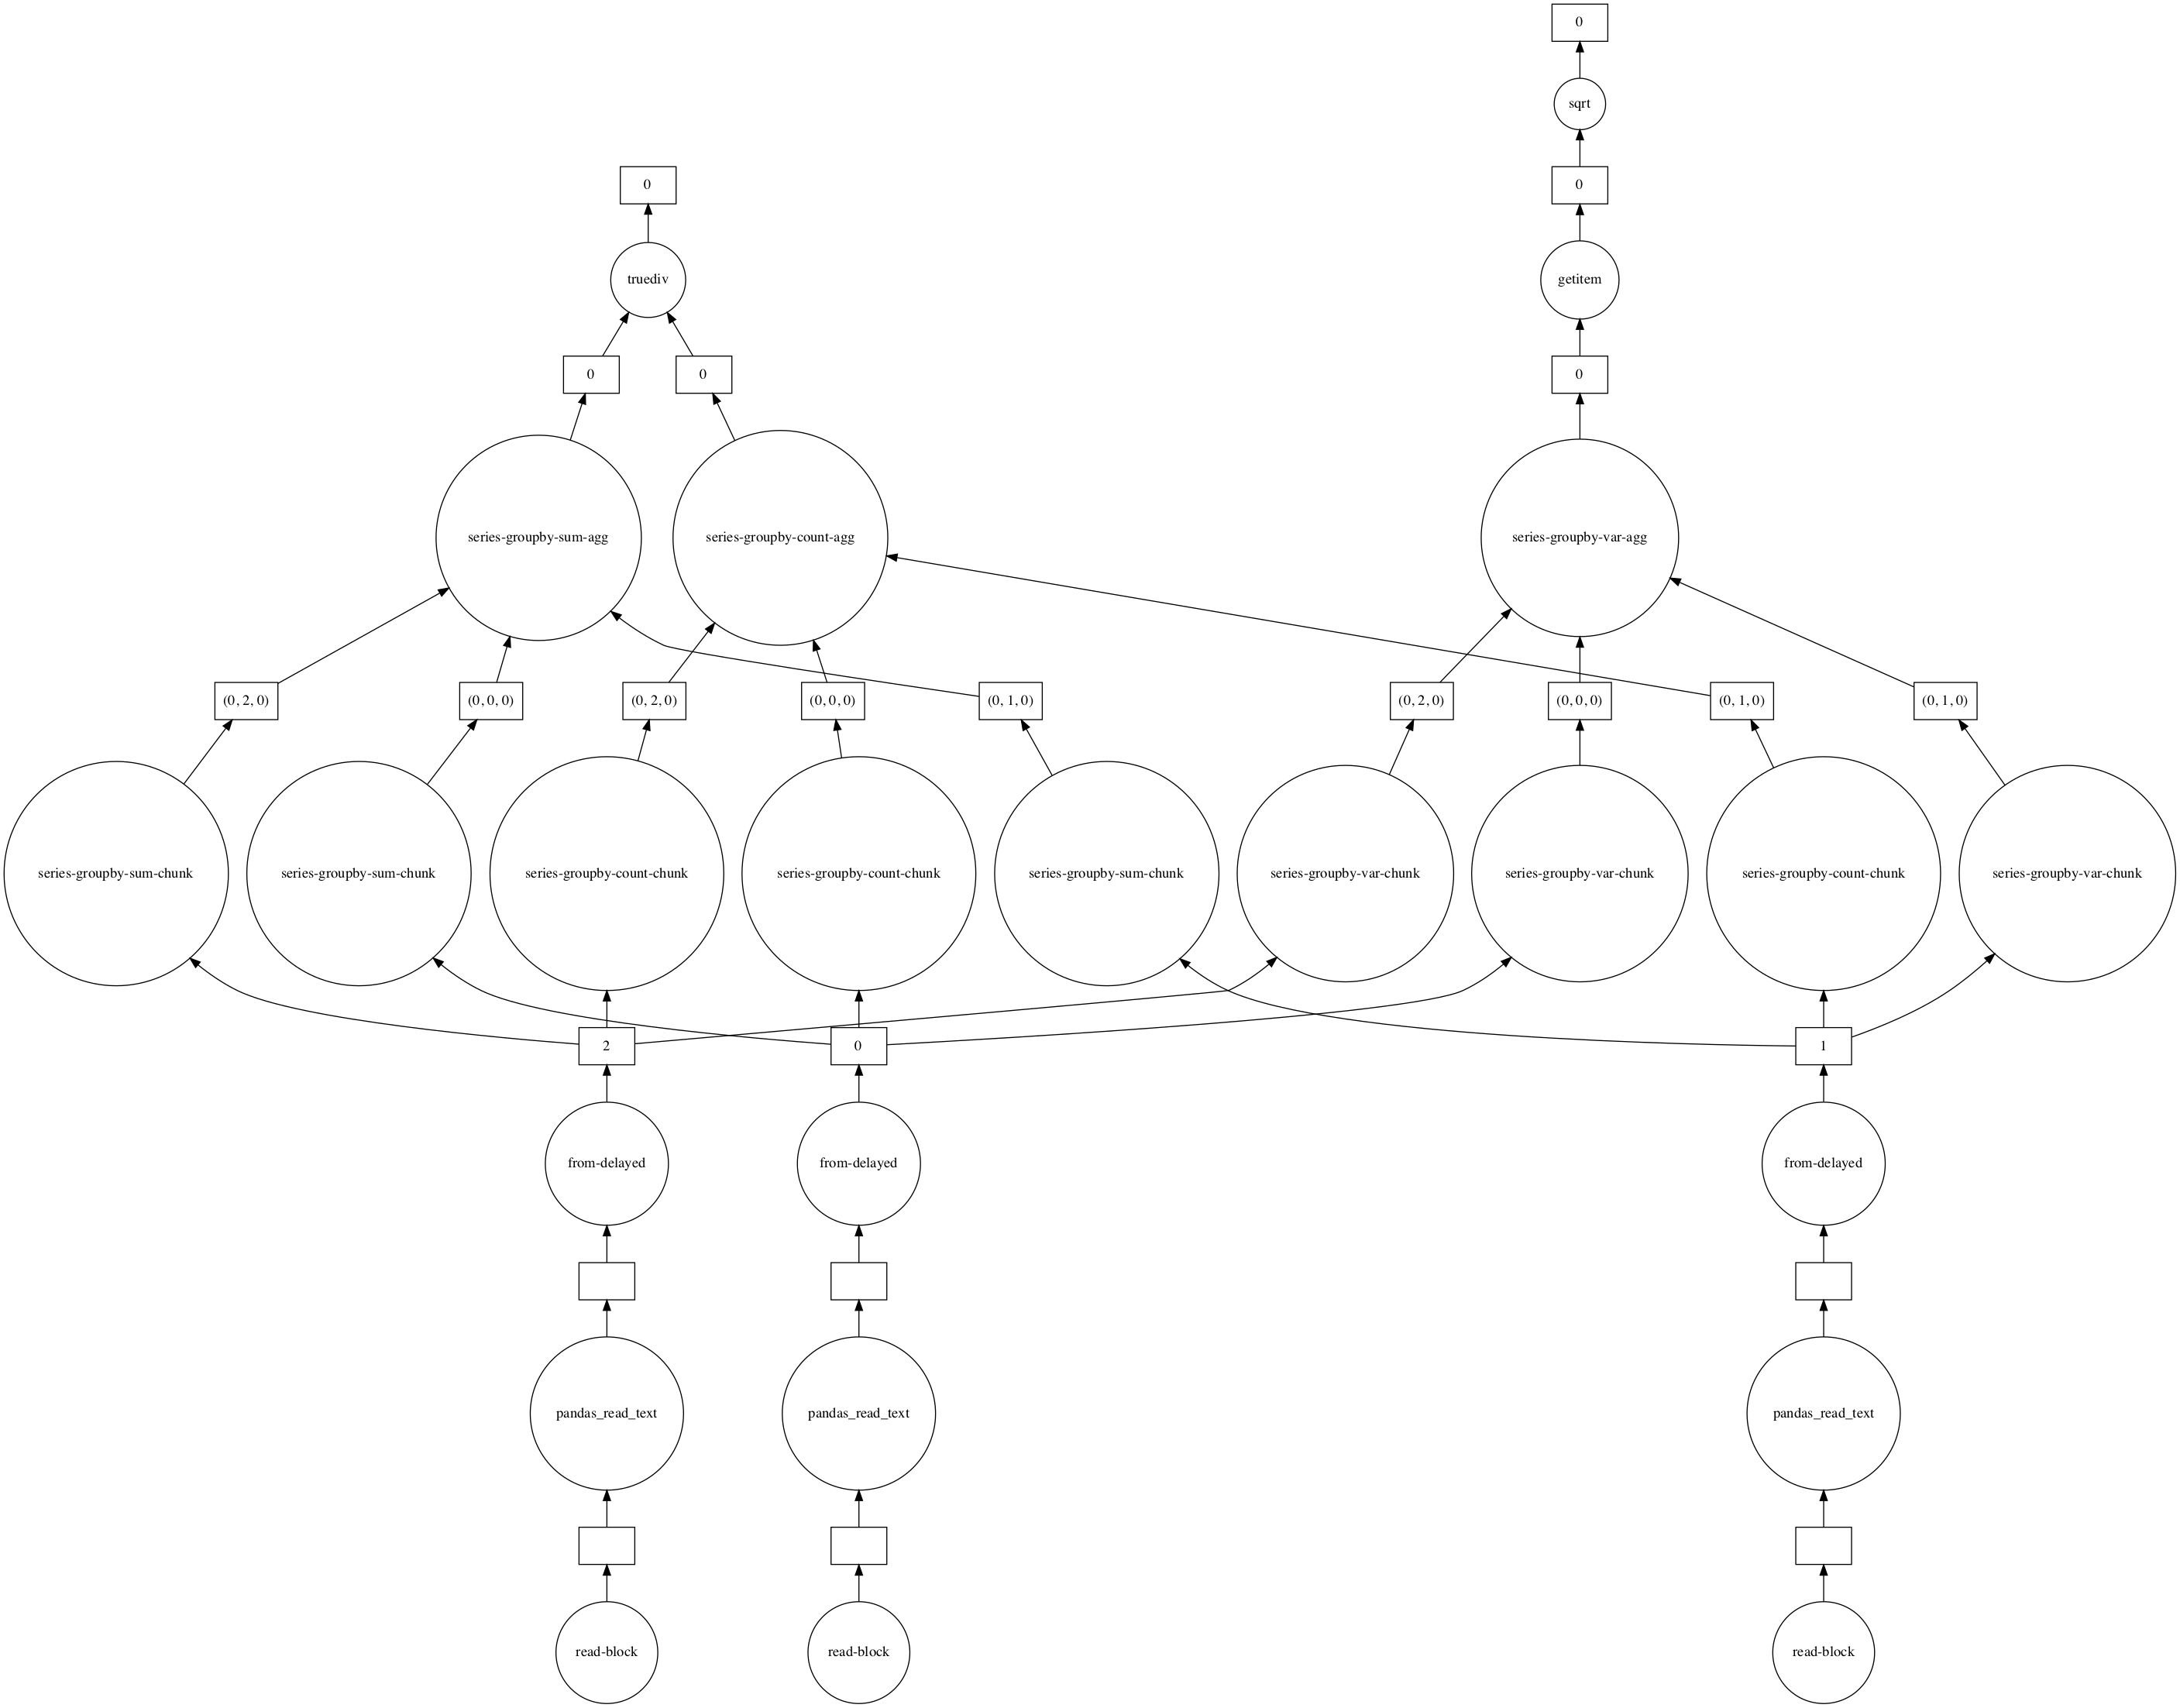

In [83]:
dask.visualize(mean_delay, std_delay)

# Map Partitions

In [6]:
sepal_length = df.sepal_length

In [15]:
sepal_length.head(3)

0    5.1
1    4.9
2    4.7
Name: sepal_length, dtype: float64

In [7]:
def add(a, b):
    x = a + b
    return x

In [16]:
res = sepal_length.map_partitions(lambda x: add(x, 500))

In [17]:
res.head(3)

0    505.1
1    504.9
2    504.7
Name: sepal_length, dtype: float64

# Set Index

In [5]:
df.head(3)

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa


In [9]:
df_var = df.set_index('variety') 
df_var

,sepal_length,sepal_width,petal_length,petal_width
npartitions=1,,,,
Setosa,float64,float64,float64,float64
Virginica,...,...,...,...


In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
def train(partition):
    est = LinearRegression()
    est.fit(partition[['sepal_length']].values, partition.petal_length.values)
    return est

In [16]:
lr_res = df_var.groupby('variety').apply(train, meta=object).compute()
lr_res

variety
Setosa        LinearRegression(copy_X=True, fit_intercept=Tr...
Versicolor    LinearRegression(copy_X=True, fit_intercept=Tr...
Virginica     LinearRegression(copy_X=True, fit_intercept=Tr...
dtype: object

In [25]:
lr_res.Setosa.coef_

array([0.13163168])

In [30]:
lr_res.Setosa.predict(np.array([3, 5]).reshape(-1, 1))

array([1.19794685, 1.46121021])